In [218]:
#### importing some libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment
from scipy.stats import norm
from scipy.stats import ttest_rel
import warnings
import itertools
import matplotlib.colors as mcolors
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
### functions to compute delta S

def sig_est(mean):
  """
  estimate standard deviation using the mean rating
  for a color-concept pair
  """
  return np.maximum(1.4 * mean * (1-mean), .1)

def compute_semantic_distance(x1, x2, x3, x4):
    """
    get semantic distance between a set of color concept
    association ratings.
    x1, x2, x3, and x4 are the ratings for four colors as
    described in https://schlosslab.discovery.wisc.edu/wp-content/uploads/2021/08/SchlossLeggonLessard2021.pdf


        concept1                concept2
          |\                       /|
          | \                     / |
       x1 |  \ x2             x3 /  | x4
          |   \                 /   |
          |    \               /    |
        color1  color2    color1  color2
    """
    num = (x1 + x4) - (x2 + x3)

    denom = np.sqrt(sig_est(x1)**2 + sig_est(x2)**2 + sig_est(x3)**2 + sig_est(x4)**2)

    p_dx_gt_zero = norm.cdf(num / denom)
    p_dx_lt_zero = 1 - p_dx_gt_zero
    semdist = np.absolute(p_dx_gt_zero - p_dx_lt_zero)

    return semdist



### this function gets all the delta S values for a pair of concepts
def get_all_semdists(concept1, concept2):
    """
    compute semantic distances between all color pairs for a concept
    concept1 & concept2 are color-concept association
    vectors for two concepts
    """
    dists = []
    pairs = []

    for color1 in range(concept1.shape[0]):
        for color2 in range(color1):
            x1, x2 = concept1[color1], concept1[color2]
            x3, x4 = concept2[color1], concept2[color2]
            #semdists[color1][color2] = get_semdist(x1, x2, x3, x4)
            if np.any(np.isnan([x1,x2,x3,x4])):
              continue
            dists.append(compute_semantic_distance(x1, x2, x3, x4))
            pairs.append(tuple([color1,color2]))


    return dists, pairs



def compute_total_variation(vec1, vec2):
  """
  compute total variation distance between two vectors
  """
  return np.sum(np.abs(vec1-vec2))



def assignment_solve( ratings, method="balanced"):
    """
    Input is a m x n array of (concepts) x (colors) filled with association ratings
    Output is a list of length m with the index of the color that should be associated with each concept
    """
    m,n = ratings.shape
    assert m <= n, "More concepts than colors, assignment impossible!"

    # isolated merit function (only considers target in isolation)
    if method == "isolated":
        merit_matrix = ratings

    # balanced merit function (balances ratings of target vs off-target objects with each color)
    elif method == "balanced":
        t = 1  # this is the penalty parameter. t=1 for balanced, t=0 recovers isolated case.
        merit_matrix = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                merit_matrix[i,j] = ratings[i,j] - t*ratings[np.arange(m)!=i,j].max()



    # baseline merit function (uniformly bad assignment)
    elif method == "baseline":
        merit_matrix = np.zeros((m,n))
        for i in range(m):
            for j in range(n):
                merit_matrix[i,j] = -abs( ratings[i,j] - ratings[np.arange(m)!=i,j].max() )

    else:
        assert False, "unknown method in assignment problem"

    row_ind, col_ind = linear_sum_assignment( merit_matrix, maximize=True )
    return col_ind



def visualize_color_patches(hex_colors, concept_names):
    fig, ax = plt.subplots(1, len(hex_colors), figsize=(len(hex_colors) * 2, 2), facecolor=(143/255, 143/255, 143/255))
    
    if len(hex_colors) == 1:
        ax = [ax]
    
    for i, color in enumerate(hex_colors):
        ax[i].add_patch(patches.Rectangle((0, 0), 1, 1, color=color))
        ax[i].set_xlim(0, 1)
        ax[i].set_ylim(0, 1)
        ax[i].axis('off')
        ax[i].set_title(concept_names[i], fontsize=10)
        ax[i].set_facecolor((143/255, 143/255, 143/255))
    
    plt.show()


def make_ratings_mat(grouped_ratings_df):
    
    mat = np.zeros((len(np.unique(grouped_ratings_df.prompt)),71))
    for i,con in enumerate(np.unique(grouped_ratings_df.prompt)):
        ds = grouped_ratings_df[grouped_ratings_df.prompt==con]
        mat[i,:] = ds.iloc[:,3].values


    mat = pd.DataFrame(mat, index =np.unique(grouped_ratings_df.prompt), columns = np.arange(mat.shape[1]) )
    cmeans = mat.mean().values
    return mat, cmeans




In [3]:
color_dict = pd.read_csv('https://raw.githubusercontent.com/kushinm/cc-assoc-ratings/main/UW71coordinates_long.csv')
p1 = ['corn','carrot','grape','banana']
p2 =['sleeping','driving','peach','cherry']
p3 = ['working','leisure','safety','comfort']
p4 = ['eggplant','celery','efficiency','speed']
p5= ['working','leisure','grape','banana']
p6 = ['eggplant','celery','peach','cherry']
p7 = ['corn','carrot','safety','comfort']
p8 = ['sleeping','driving','efficiency','speed']


p9 = ['corn','carrot','peach','cherry']
p10 = ['sleeping','driving','grape','banana']
p11 = ['working','leisure','efficiency','speed']
p12 = ['eggplant','celery','safety','comfort']
p13 = ['working','leisure','peach','cherry']
p14 = ['eggplant','celery','grape','banana']
p15 = ['corn','carrot','efficiency','speed',]
p16 = ['sleeping','driving','safety','comfort']
plist=[p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16]


In [4]:
### load human ratings and average ratings

set_1_raw = pd.read_csv('../../data/uw71_set1_redo_raw.csv')
set_2_raw = pd.read_csv('../../data/uw71_set2_raw.csv')
set_3_raw = pd.read_csv('../../data/uw71_set3_raw.csv')
set1_grouped = set_1_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
set2_grouped = set_2_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
set3_grouped = set_3_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()

ratings1,ratings_cmeans1= make_ratings_mat(set1_grouped)
ratings2,ratings_cmeans2= make_ratings_mat(set2_grouped)
ratings3,ratings_cmeans3= make_ratings_mat(set3_grouped)

concept_list = set1_grouped.pivot(index=['prompt','concept'], columns='color_index', values='mean_rating').reset_index().sort_values(by=['concept','prompt']).reset_index(drop=True)['prompt'].values
concept_list.sort()
concept_order  = {concept: i for i, concept in enumerate(concept_list)}

### vertically stack the ratings matrices
ratings_human = pd.concat([ratings1,ratings2,ratings3])
ratings_human['concept'] = ratings_human.index
ratings_human = ratings_human.reset_index(drop=True)




In [5]:
gpt_assoc_hex_images = pd.read_csv('../../data/all_stim_hex_plus_patch.csv', index_col=0)
gpt_assoc_hex_images = gpt_assoc_hex_images.pivot(index='concept', columns='color_index', values='response').rename_axis(None, axis=1).reset_index()

In [6]:
ratings_human = ratings_human[ratings_human['concept'].isin(set_3_raw.prompt.unique())].reset_index(drop=True)
gpt_assoc_hex_images = gpt_assoc_hex_images[gpt_assoc_hex_images['concept'].isin(set_3_raw.prompt.unique())].reset_index(drop=True)

In [7]:
true_assignments = []
for i in range(len(plist)):
    concepts = plist[i]
    # print(concepts)
    subset = ratings_human[ratings_human['concept'].isin(concepts)]

     # Sort the subset DataFrame by the 'concept' column following the order in 'concepts'
    subset['concept'] = pd.Categorical(subset['concept'], categories=concepts, ordered=True)
    subset = subset.sort_values('concept')
    
    ratings = subset.drop('concept', axis=1).values
    color_assignment = assignment_solve(ratings, method='balanced')
    selected_colors = color_dict.iloc[color_assignment]['color_hex'].tolist()
    
    # print('Optimal color assignment for concept set {}:'.format(i+1))
    # print(selected_colors)
    # visualize_color_patches(selected_colors, concepts)
    
    # print('')
    assignment_dict = {concept: color for concept, color in zip(concepts, selected_colors)}
    true_assignments.append(assignment_dict)

In [8]:
gpt_assignments = []
for i in range(len(plist)):
    concepts = plist[i]
    subset = gpt_assoc_hex_images[gpt_assoc_hex_images['concept'].isin(concepts)]
    
    subset['concept'] = pd.Categorical(subset['concept'], categories=concepts, ordered=True)
    subset = subset.sort_values('concept')

    ratings = subset.drop('concept', axis=1).values
    color_assignment = assignment_solve(ratings, method='balanced')
    selected_colors = color_dict.iloc[color_assignment]['color_hex'].tolist()
    
    # print('Optimal color assignment for concept set {}:'.format(i+1))
    # print(selected_colors)
    # visualize_color_patches(selected_colors, concepts)
    # print('')
    assignment_dict = {concept: color for concept, color in zip(concepts, selected_colors)}
    gpt_assignments.append(assignment_dict)


In [9]:


{f"{ind}":val for ind,val in enumerate(gpt_assignments)}

{'0': {'corn': '#c7b88b',
  'carrot': '#cc4f1b',
  'grape': '#600b84',
  'banana': '#d0e942'},
 '1': {'sleeping': '#000000',
  'driving': '#d5b811',
  'peach': '#f7a75a',
  'cherry': '#e81a4b'},
 '2': {'working': '#777777',
  'leisure': '#cd26c7',
  'safety': '#73cf10',
  'comfort': '#632b14'},
 '3': {'eggplant': '#72005e',
  'celery': '#608218',
  'efficiency': '#b9b9b9',
  'speed': '#ea1d1d'},
 '4': {'working': '#777777',
  'leisure': '#4bcf8e',
  'grape': '#512d5f',
  'banana': '#d5b811'},
 '5': {'eggplant': '#3518ad',
  'celery': '#aac510',
  'peach': '#f7a75a',
  'cherry': '#ea1d1d'},
 '6': {'corn': '#d5b811',
  'carrot': '#cc4f1b',
  'safety': '#73cf10',
  'comfort': '#632b14'},
 '7': {'sleeping': '#000000',
  'driving': '#d5b811',
  'efficiency': '#67cf5c',
  'speed': '#c94e4b'},
 '8': {'corn': '#d5b811',
  'carrot': '#cc4f1b',
  'peach': '#f1a78a',
  'cherry': '#e81a4b'},
 '9': {'sleeping': '#000000',
  'driving': '#ea1d1d',
  'grape': '#72005e',
  'banana': '#f7db7c'},
 '10': 

### Check data

In [137]:
### read in all the .csv files in data/assignment_inference_data
import os
import pandas as pd
import numpy as np
import json
path = '../../data/assignment_inference_data'
files = os.listdir(path)
ai_df = pd.DataFrame()
for file in files:
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(path, file))
        df['file'] = file
        ai_df = pd.concat([ai_df, df])

In [153]:
### get then number of unique subject ids in each condition
ai_df.groupby('condition').subject_id.nunique()

condition
"set1"    43
"set2"    50
Name: subject_id, dtype: int64

In [266]:
ai_df[ai_df.trial_index==91].responses

91    {"colorDifficulty":"No","colorBlind":"No"}
91    {"colorDifficulty":"No","colorBlind":"No"}
91    {"colorDifficulty":"No","colorBlind":"No"}
91    {"colorDifficulty":"No","colorBlind":"No"}
91    {"colorDifficulty":"No","colorBlind":"No"}
                         ...                    
91    {"colorDifficulty":"No","colorBlind":"No"}
91    {"colorDifficulty":"No","colorBlind":"No"}
91    {"colorDifficulty":"No","colorBlind":"No"}
91    {"colorDifficulty":"No","colorBlind":"No"}
91    {"colorDifficulty":"No","colorBlind":"No"}
Name: responses, Length: 93, dtype: object

In [246]:
ai_demographics = ai_df[ai_df['trial_type'] == 'survey-text']



ages = pd.json_normalize([json.loads(x) for x in ai_demographics['responses']])['Age']
genders = pd.json_normalize([json.loads(x) for x in ai_demographics['responses']])['Gender']
races = pd.json_normalize([json.loads(x) for x in ai_demographics['responses']])['Race']
# Convert to numeric, coerce errors to NaN
ages = pd.to_numeric(ages, errors='coerce')

# Calculate mean, dropping NaN values
mean_age = ages.mean()



In [150]:
for gender in genders:
    print(gender)

female
Non-Binary
female
female
female
Male
male
Male
Male
m
Female
female
Female
Female
Male
female
female
female
Female
Female
Female
Female
Female
male
Female
F
Male
male
Male
Male
Male
Female
Female
Female 
Male
Woman
Female
Female
Female
male
Female
Male
female
Female
Female
Female
Female
Male
female
2
Non-Binary
female
Female
female
Female
female
Female
Male
Male
female
female
Non-Binary
female
Female
Female
male
FEMALE
Female
female
Boy
female
Men
1
female
Female
female
female
Male
Male
Female
female
Male
Male
Female
female
Female
Male
Female
female
female
female
female
Male


93

In [247]:
for race in races:
    print(race)

white
White
white
white
white
Mexican
Arab 
Asian
White
a
White/Caucasian
white
White
White/Caucasian
White
white
White
white
Whiite
White
Asian
White
White
white
White
Chinese American
White
white
White 
Indian-American
White
White
White
White 
White
Biracial (Asian/Hispanic)
White
White
Asian
white
White
White
white
White
Asian
White
Hispanice/white
White
white
2
Hispanic/Native American
white
Jordanian 
white
Hispanic
white
White
White
Asian
white
white
Hispanic/Native American
white
White
African American
Asian
White
White
Asian
A
white
Asian
1
white 
White
Asian, Chinese
white
White
White
indian
white
White
White
White
White
Asian
White/Asian
White
white
white
white
white
Indian


In [12]:
ai_trials = ai_df[ai_df['trial_type'] == 'assignment-inference']
ai_trials = ai_trials[~ai_trials['category'].isin(['"catch_trial"','"practice_trial"'])].reset_index(drop=True)

In [13]:
ai_trials.groupby('category')['total accuracy'].mean()

category
"0"     2.580000
"1"     3.157500
"10"    1.630814
"11"    3.546512
"12"    3.348837
"13"    3.468023
"14"    3.575581
"15"    3.404070
"2"     2.050000
"3"     3.022500
"4"     2.780000
"5"     3.460000
"6"     3.032500
"7"     2.375000
"8"     3.953488
"9"     3.863372
Name: total accuracy, dtype: float64

In [14]:
print(ai_trials.columns)
ai_trials

Index(['rt', 'stimulus', 'button_pressed', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'subject_id', 'sona_id', 'success',
       'key_press', 'value', 'responses', 'question_order', 'label_options',
       'bar_cols', 'answer_key', 'label_responses', 'condition', 'repetition',
       'category', 'pal_source', 'accuracies', 'total accuracy', 'order_num',
       'file'],
      dtype='object')


,rt,stimulus,button_pressed,trial_type,trial_index,time_elapsed,internal_node_id,subject_id,sona_id,success,...,answer_key,label_responses,condition,repetition,category,pal_source,accuracies,total accuracy,order_num,file
0,12340.0,NaN,NaN,assignment-inference,11,67393,0.0-11.0,pv8mjorbc3,88441,NaN,...,"[""working"",""leisure"",""peach"",""cherry""]","[""working"",""leisure"",""peach"",""cherry""]","""set1""",0.0,"""12""","""uw_71""","[1,1,1,1]",4.0,4.0,pv8mjorbc3.csv
1,18232.0,NaN,NaN,assignment-inference,12,85627,0.0-12.0,pv8mjorbc3,88441,NaN,...,"[""working"",""leisure"",""efficiency"",""speed""]","[""working"",""efficiency"",""leisure"",""speed""]","""set1""",0.0,"""10""","""uw_71""","[1,0,0,1]",2.0,4.0,pv8mjorbc3.csv
2,12265.0,NaN,NaN,assignment-inference,13,97893,0.0-13.0,pv8mjorbc3,88441,NaN,...,"[""corn"",""carrot"",""efficiency"",""speed""]","[""corn"",""carrot"",""speed"",""efficiency""]","""set1""",0.0,"""14""","""uw_71""","[1,1,0,0]",2.0,4.0,pv8mjorbc3.csv
3,13394.0,NaN,NaN,assignment-inference,14,111288,0.0-14.0,pv8mjorbc3,88441,NaN,...,"[""corn"",""carrot"",""peach"",""cherry""]","[""corn"",""carrot"",""peach"",""cherry""]","""set1""",0.0,"""8""","""uw_71""","[1,1,1,1]",4.0,4.0,pv8mjorbc3.csv
4,14018.0,NaN,NaN,assignment-inference,15,125308,0.0-15.0,pv8mjorbc3,88441,NaN,...,"[""eggplant"",""celery"",""safety"",""comfort""]","[""comfort"",""celery"",""eggplant"",""safety""]","""set1""",0.0,"""11""","""uw_71""","[0,1,0,0]",1.0,4.0,pv8mjorbc3.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,6573.0,NaN,NaN,assignment-inference,85,617306,0.0-85.0,hja5vlht4p,88481,NaN,...,"[""sleeping"",""driving"",""peach"",""cherry""]","[""sleeping"",""driving"",""peach"",""cherry""]","""set2""",7.0,"""1""","""uw_71""","[1,1,1,1]",4.0,0.0,hja5vlht4p.csv
5948,6751.0,NaN,NaN,assignment-inference,86,624058,0.0-86.0,hja5vlht4p,88481,NaN,...,"[""corn"",""carrot"",""grape"",""banana""]","[""banana"",""carrot"",""grape"",""corn""]","""set2""",7.0,"""0""","""uw_71""","[0,1,1,0]",2.0,0.0,hja5vlht4p.csv
5949,7012.0,NaN,NaN,assignment-inference,87,631071,0.0-87.0,hja5vlht4p,88481,NaN,...,"[""corn"",""carrot"",""safety"",""comfort""]","[""corn"",""carrot"",""safety"",""comfort""]","""set2""",7.0,"""6""","""uw_71""","[1,1,1,1]",4.0,0.0,hja5vlht4p.csv
5950,9665.0,NaN,NaN,assignment-inference,88,640737,0.0-88.0,hja5vlht4p,88481,NaN,...,"[""eggplant"",""celery"",""peach"",""cherry""]","[""eggplant"",""celery"",""peach"",""cherry""]","""set2""",7.0,"""5""","""uw_71""","[1,1,1,1]",4.0,0.0,hja5vlht4p.csv


In [15]:
subject_id=[]
rt=[]
trial_index=[]
#label_option=[]
bar_col=[]
answer=[]
response=[]
condition=[]
repetition=[]
category=[]
pal_source=[]
accuracy=[]
total_accuracy=[]
order_num=[]
x=0



for index,row in ai_trials.iterrows():
    
    for i in range(4):
        rt.append(row.rt)
        trial_index.append(index)
        #label_option.append( eval(row.label_options))
        bar_col.append(eval(row.bar_cols)[i])
        answer.append(eval(row.answer_key)[i])
        response.append( eval(row.label_responses)[i])
        condition.append(row.condition)
        repetition.append(row.repetition)
        category.append(row.category)
        pal_source.append( row.pal_source)
        accuracy.append( eval(row.accuracies)[i])
        total_accuracy.append(row['total accuracy'])
        order_num.append(row.order_num)
        subject_id.append(row.subject_id)
        


In [16]:
cat_con_dict = {'fruits':['cherry','peach','grape','banana'],'vegetables':['corn','carrot','celery','eggplant'],
               'activities':['working','sleeping','driving','leisure'],'features':['efficiency','speed','safety','comfort']}


con_cat_dict = {i: k for k, v in cat_con_dict.items() for i in v}

In [17]:
clean_df_human = pd.DataFrame({'subject_id':subject_id,'trial_index':trial_index,'condition':condition,'pal_source':pal_source,'order_num':order_num,\
               'category':category,'repetition':repetition,'answer':answer,\
               'bar_col':bar_col,'response':response,\
             'accuracy':accuracy,'total_accuracy':total_accuracy,'rt':rt})

In [18]:
clean_df_human = clean_df_human[~clean_df_human.response.isin([' ____ ','____'])].reset_index(drop=True)

In [19]:
clean_df_human['concreteness_cond'] = clean_df_human.apply(lambda x: 'conc' if x.category in ['"8"','"13"'] \
                                                   else ('abs' if x.category in ['"10"','"15"']\
                                                              else'mix'), axis=1 )

clean_df_human['context']= clean_df_human.apply(lambda x: 'within' if x.concreteness_cond in ['conc','abs'] else 'across', axis = 1)

clean_df_human['concept_cat'] = clean_df_human.apply(lambda x:con_cat_dict[x.answer], axis = 1)

clean_df_human['con_pal_conc'] = clean_df_human['condition'] +clean_df_human['category'].str.split('"').str[1] + clean_df_human['answer']

clean_df_human['category'] = clean_df_human['category'].str.replace('"','')
# clean_df_human['category'] = clean_df_human['category'].astype('int')
# # clean_df_human['category'] = clean_df_human['category']-1

In [20]:
clean_df_human.head()

,subject_id,trial_index,condition,pal_source,order_num,category,repetition,answer,bar_col,response,accuracy,total_accuracy,rt,concreteness_cond,context,concept_cat,con_pal_conc
0,pv8mjorbc3,0,"""set1""","""uw_71""",4.0,12,0.0,working,#777777,working,1,4.0,12340.0,mix,across,activities,"""set1""12working"
1,pv8mjorbc3,0,"""set1""","""uw_71""",4.0,12,0.0,leisure,#4bcf8e,leisure,1,4.0,12340.0,mix,across,activities,"""set1""12leisure"
2,pv8mjorbc3,0,"""set1""","""uw_71""",4.0,12,0.0,peach,#f1a78a,peach,1,4.0,12340.0,mix,across,fruits,"""set1""12peach"
3,pv8mjorbc3,0,"""set1""","""uw_71""",4.0,12,0.0,cherry,#ea1d1d,cherry,1,4.0,12340.0,mix,across,fruits,"""set1""12cherry"
4,pv8mjorbc3,1,"""set1""","""uw_71""",4.0,10,0.0,working,#632b14,working,1,2.0,18232.0,abs,within,activities,"""set1""10working"


In [21]:

plot_df_human = clean_df_human.groupby(['bar_col','con_pal_conc','subject_id','category','condition','response' ]).\
apply(lambda x: len(x)/8).reset_index(name= 'num_times_picked')
col_dict= {a:a for a in plot_df_human.bar_col.unique()}

pair_labels = []
for index, row in clean_df_human.iterrows():
    if row.answer in ['grape','banana']:
        pair_labels.append('fruit1')
    elif row.answer in ['peach','cherry']:
        pair_labels.append('fruit2')
    elif row.answer in ['carrot','corn']:
        pair_labels.append('veg1')  
    elif row.answer in ['celery','eggplant']:
        pair_labels.append('veg2')
    elif row.answer in ['safety','comfort']:
        pair_labels.append('feat2')
    elif row.answer in ['speed','efficiency']:
        pair_labels.append('feat1')
    elif row.answer in ['working','leisure']:
        pair_labels.append('act2')
    elif row.answer in ['driving','sleeping']:
        pair_labels.append('act1')

clean_df_human['pair_labels'] = pair_labels

In [22]:
cond_acc = clean_df_human.groupby(['condition','concreteness_cond'])[['total_accuracy','rt']].agg(['mean','sem']).reset_index()
cond_acc.columns = ['_'.join(col).strip('_') for col in cond_acc.columns.values]


In [68]:
plot_df_human = clean_df_human.groupby(['bar_col','con_pal_conc','subject_id','category','condition','response' ]).\
apply(lambda x: len(x)/8).reset_index(name= 'num_times_picked')
col_dict= {a:a for a in plot_df_human.bar_col.unique()}

In [69]:
plot_df_backup = plot_df_human.copy()
rows_to_add = []

for pal in plot_df_backup.category.unique():
    dp = plot_df_backup[plot_df_backup.category == pal]
    for cond in dp.condition.unique():
        dpp = dp[dp.condition == cond]
        concepts = dpp.response.unique()
        for col in dpp.bar_col.unique():
            dppp = dpp[dpp.bar_col == col]
            for subj in dppp.subject_id.unique():
                dp_ = dppp[dppp.subject_id == subj]
                for conc in concepts:
                    if conc not in dp_.response.unique():
                        rows_to_add.append([col, 'NA', subj, pal, cond, conc, 0])

# Create a DataFrame from the collected rows and concatenate it with the original DataFrame
if rows_to_add:
    new_rows_df = pd.DataFrame(rows_to_add, columns=plot_df_human.columns)
    plot_df_human = pd.concat([plot_df_human, new_rows_df], ignore_index=True)


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
p1 = ['corn','carrot','grape','banana']
p2 =['sleeping','driving','peach','cherry']
p3 = ['working','leisure','safety','comfort']
p4 = ['eggplant','celery','efficiency','speed']
p5= ['working','leisure','grape','banana']
p6 = ['eggplant','celery','peach','cherry']
p7 = ['corn','carrot','safety','comfort']
p8 = ['sleeping','driving','efficiency','speed']
p9 = ['corn','carrot','peach','cherry']
p10 = ['sleeping','driving','grape','banana']
p11 = ['working','leisure','efficiency','speed']
p12 = ['eggplant','celery','safety','comfort']
p13 = ['working','leisure','peach','cherry']
p14 = ['eggplant','celery','grape','banana']
p15 = ['corn','carrot','efficiency','speed',]
p16 = ['sleeping','driving','safety','comfort']
plist=[
    p1,p2,p3,p4,p5,p6,p7,p8,
       p9,p10,p11,p12,p13,p14,p15,p16]

true_assignments =  [{
        "corn": "#c7b88b",
        "carrot": "#cc4f1b",
        "grape": "#600b84",
        "banana": "#d0e942"
    },{
        "sleeping": "#000000",
        "driving": "#d5b811",
        "peach": "#f7a75a",
        "cherry": "#e81a4b"
    },{
        "working": "#777777",
        "leisure": "#cd26c7",
        "safety": "#73cf10",
        "comfort": "#632b14"
    },{
        "eggplant": "#72005e",
        "celery": "#608218",
        "efficiency": "#b9b9b9",
        "speed": "#ea1d1d"
    }, {
        "working": "#777777",
        "leisure": "#4bcf8e",
        "grape": "#512d5f",
        "banana": "#d5b811"
    }, {
        "eggplant": "#3518ad",
        "celery": "#aac510",
        "peach": "#f7a75a",
        "cherry": "#ea1d1d"
    },{
        "corn": "#d5b811",
        "carrot": "#cc4f1b",
        "safety": "#73cf10",
        "comfort": "#632b14"
    }, {
        "sleeping": "#000000",
        "driving": "#d5b811",
        "efficiency": "#67cf5c",
        "speed": "#c94e4b"
    },    
     {
        "corn": "#d5b811",
        "carrot": "#cc4f1b",
        "peach": "#f1a78a",
        "cherry": "#e81a4b"
    }, {
        "sleeping": "#000000",
        "driving": "#ea1d1d",
        "grape": "#72005e",
        "banana": "#f7db7c"
    },{
        "working": "#632b14",
        "leisure": "#cd26c7",
        "efficiency": "#1c3d61",
        "speed": "#ea1d1d"
    }, {
        "eggplant": "#600b84",
        "celery": "#a3c55b",
        "safety": "#d5b811",
        "comfort": "#632b14"
    }, {
        "working": "#777777",
        "leisure": "#4bcf8e",
        "peach": "#f1a78a",
        "cherry": "#ea1d1d"
    }, {
        "eggplant": "#512d5f",
        "celery": "#96c58c",
        "grape": "#cd26c7",
        "banana": "#d5b811"
    }, {
        "corn": "#d5b811",
        "carrot": "#ac6619",
        "efficiency": "#73f5b0",
        "speed": "#ea1d1d"
    }, {
        "sleeping": "#000000",
        "driving": "#ea1d1d",
        "safety": "#d0e942",
        "comfort": "#632b14"
    }
]


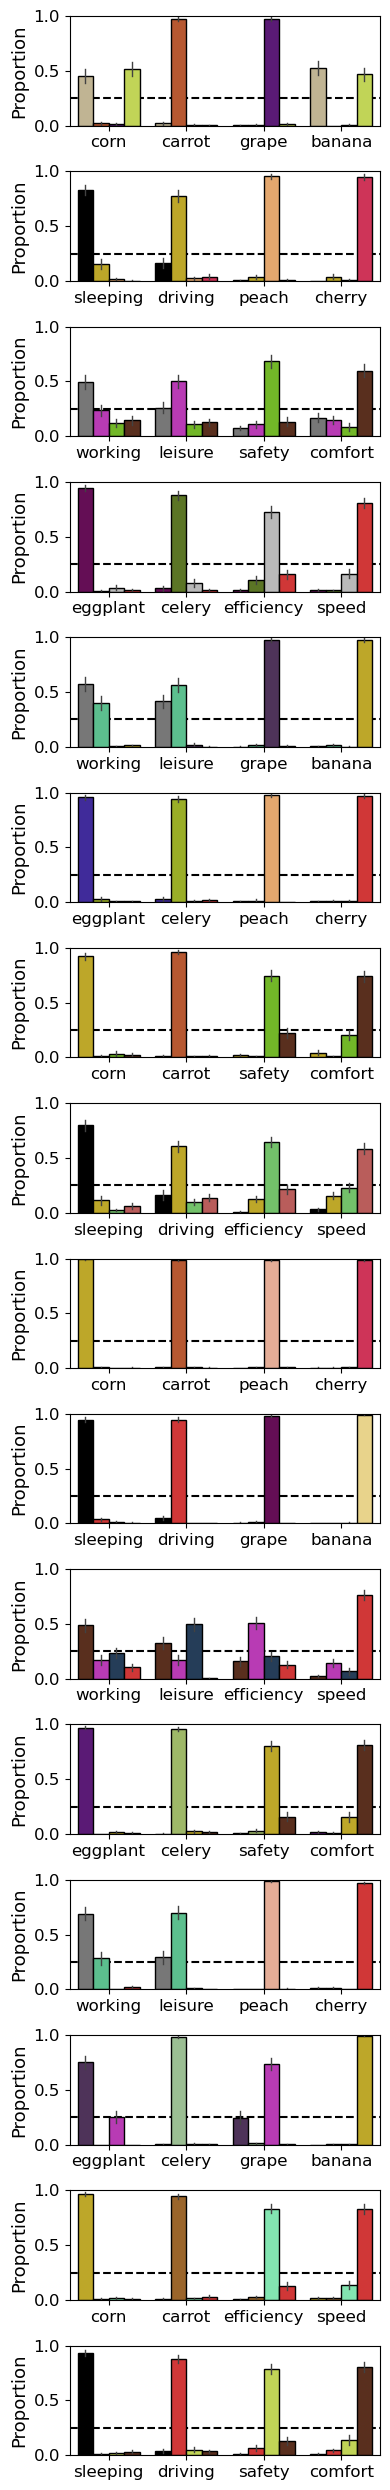

In [71]:
fig = plt.figure(figsize=(4,25))
plt.rcParams['pdf.fonttype'] = 42
sp=1

for j in range(16):
    

    pdf = plot_df_human[(plot_df_human.category ==f'{j}')]
    
    hue_ord=[]
    this_p = plist[j]
    for p in this_p:
        hue_ord.append(true_assignments[j][p])
    

    #sns.set_theme(style="white",rc = {'patch.linewidth': 0.5, 'patch.edgecolor':'black',})

    g = sns.barplot(ax = fig.add_subplot(16,1,sp),
        data=pdf,
        color = 'black',
        x="response", 
        y="num_times_picked",
        hue="bar_col", 
        palette =col_dict,
        errorbar='se', 
        order = plist[j], 
        hue_order= hue_ord,
        errwidth=1,
        edgecolor='black'
    )
    plt.axhline( y=0.25, ls='--', c='black', zorder=0)
    plt.xlabel('')
    ax = plt.gca()
    ax.get_legend().remove()
    plt.ylabel('Proportion', fontsize=13)
    plt.ylim(0,1)
    plt.yticks([0,0.5,1])
    plt.tick_params(labelsize=12)
    
  
    #plt.show()

    
    sp+=1
plt.tight_layout()

plt.savefig(f'../../plots/match_task_patterns_humans.pdf',format='pdf')
    


In [27]:
# ratings3['concept'] = ratings3.index
# ratings3 = ratings3.reset_index(drop=True)
# ratings3 = ratings3[['concept'] + [col for col in ratings2.columns if col != 'concept']]
# ratings3

In [28]:
from tqdm import tqdm

num_iters = 1000
method = 'balanced'
cdicts=[]
mc_iter=[]
model_color_pick=[]
model_color_hex=[]
gt_color_pic=[]
palette=[]
bar_concepts = []
p_counter = 0

bar_ords = []
for p in plist:

    temp = sorted(p)     
    res = [temp.index(i) for i in p] 
    bar_ords.append(res)


for pal in plist:
    concepts = pal.copy()
    concepts.sort()
 

    ds = gpt_assoc_hex_images[gpt_assoc_hex_images.concept.isin(concepts)]

    ds_a = np.array(ds.loc[:, ds.columns != 'concept'])

    soln = assignment_solve(ds_a, method=method) ##solve using old association ratings


    soln_a = ds_a[:,soln]

    soln_inds = assignment_solve(soln_a, method=method) 

    col2ans_dict = dict(zip(soln_inds,soln))
    temp_cdict= dict(zip(soln_inds,color_dict.iloc[list(col2ans_dict.values())]['color_hex'].values))
    temp_cdict
    cdicts.append(temp_cdict)

    c=[]

    for i in range(num_iters):
        ds_ab = np.random.normal(loc=soln_a, scale =(1.4*(soln_a*(1-soln_a))),size= soln_a.shape)
        c.append(assignment_solve(ds_ab))

    for i in range(len(c)):
        gt_c = 0
        for j in c[i]:
            palette.append(p_counter)

            bar_concepts.append(concepts[gt_c])

            gt_color_pic.append(soln_inds[gt_c])
            gt_c+=1

            model_color_pick.append(j)
            mc_iter.append(i)
            model_color_hex.append(color_dict[color_dict.color_index == col2ans_dict[j]]['color_hex'].values[0])

    p_counter+=1


In [29]:
simulation_df= pd.DataFrame(list(zip(model_color_hex,model_color_pick,gt_color_pic,palette,bar_concepts,mc_iter)), columns = ['color','guess','answer','pal','concept','mciter'])


In [30]:

plot_df_sim = simulation_df.groupby(['pal','concept','guess','color']).apply(lambda x: len(x.guess)/num_iters).reset_index(name= 'num_times_picked')
temp_rows = []

for this_pal in range(16):
    cols = np.unique(plot_df_sim[plot_df_sim.pal==this_pal].color)
    for this_concept in np.unique(plot_df_sim[plot_df_sim.pal==this_pal].concept): 
        i=0 #way to keep track of guess numbers
        for this_color in cols:
            if this_color not in np.unique(plot_df_sim[(plot_df_sim.pal==this_pal) &( plot_df_sim.concept==this_concept)].color):
                guess_vals = np.setdiff1d([0,1,2,3],plot_df_sim[(plot_df_sim.pal==this_pal) &( plot_df_sim.concept==this_concept)].guess)
                if len(guess_vals>1):
                    temp_rows.append({
                        'pal':this_pal,
                        'concept':this_concept,
                        'guess':guess_vals[i],
                        'color':this_color,
                        'num_times_picked':0
                    })
                    i+=1
                else:
                    temp_rows.append({
                        'pal':this_pal,
                        'concept':this_concept,
                        'guess':guess_vals[0],
                        'color':this_color,
                        'num_times_picked':0
                    })

temp_df = pd.DataFrame(temp_rows)
plot_df_sim = pd.concat([plot_df_sim, temp_df], ignore_index=True)

# fig=plt.figure(figsize=(3,25))
# plt.rcParams['pdf.fonttype'] = 42
# sp = 1
# for i in range(16):
#     pdf = plot_df[plot_df.pal == i]
#     sns.set_theme(style="white",rc = {'patch.linewidth': 0.5, 'patch.edgecolor':'black',})
   
#     g = sns.barplot(ax = fig.add_subplot(16,1,sp),
#         data=pdf,color = 'black',
#         x="concept", y="num_times_picked", hue="guess",palette = cdicts[pdf.pal.unique()[0]],
#         ci=None, order = plist[i], hue_order = bar_ords[i]
#     )
#     plt.axhline(y=0.25, ls='--', c='black')
#     plt.ylim(0,1)
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.yticks([0,0.5,1])
#     plt.tick_params(labelsize=10)
#     ax = plt.gca()
#     ax.get_legend().remove()
#     sp+=1

# plt.tight_layout()
        


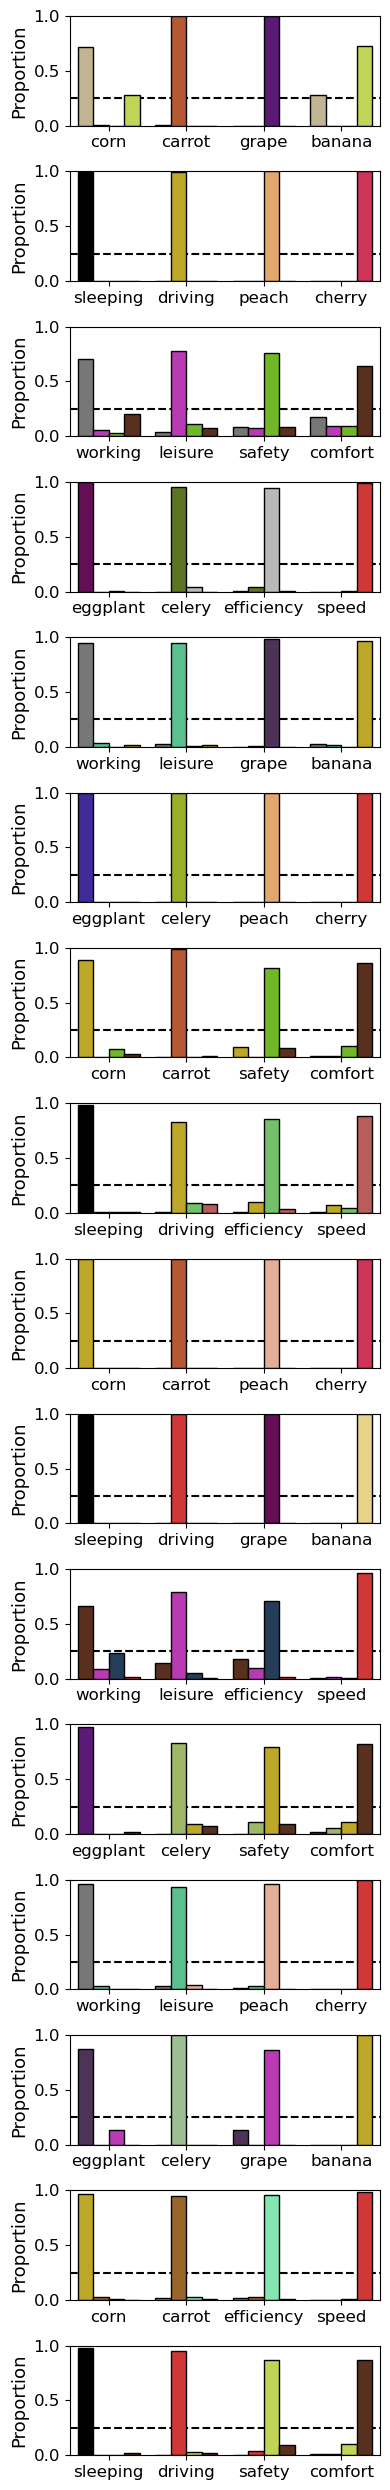

In [32]:


fig = plt.figure(figsize=(4,25))
plt.rcParams['pdf.fonttype'] = 42
sp=1

for j in range(16):
    

    pdf = plot_df_sim[(plot_df_sim.pal ==j)]
    
    hue_ord=[]
    this_p = plist[j]
    for p in this_p:
        hue_ord.append(true_assignments[j][p])
    

    #sns.set_theme(style="white",rc = {'patch.linewidth': 0.5, 'patch.edgecolor':'black',})

    g = sns.barplot(ax = fig.add_subplot(16,1,sp),
        data=pdf,color = 'black',
        x="concept", y="num_times_picked", hue="guess", palette =cdicts[pdf.pal.unique()[0]],
        errorbar='se', order = plist[j], hue_order= bar_ords[j], edgecolor='black'
    )
    plt.axhline( y=0.25, ls='--', c='black', zorder=0)
    plt.xlabel('')
    ax = plt.gca()
    ax.get_legend().remove()
    plt.ylabel('Proportion', fontsize=13)
    plt.ylim(0,1)
    plt.yticks([0,0.5,1])
    plt.tick_params(labelsize=12)

    
    sp+=1
plt.tight_layout()
plt.savefig(f'../../plots/match_task_patterns_simulated.pdf',format='pdf')

In [33]:
simulation_df['accuracy'] = simulation_df.apply(lambda x: x.guess == x.answer, axis=1)
simulation_df.pal = simulation_df.pal.astype('string')
simulation_df = simulation_df.groupby(['concept','pal'])['accuracy'].agg('mean').reset_index()
simulation_df['pal_conc'] = simulation_df['pal']+simulation_df['concept']

In [34]:

mapping = simulation_df.set_index(['concept', 'pal'])['accuracy'].to_dict()

# Add new column using map with tuple of response and category
clean_df_human['sem_contrast'] = clean_df_human.apply(
    lambda x: mapping.get((x['answer'], x['category']), None), 
    axis=1
)

In [35]:
clean_df_human_subject_level = clean_df_human.groupby(['subject_id','concept_cat','answer','category'], as_index=False).agg({
    'sem_contrast': 'mean',
    'accuracy': 'mean'
}).reset_index(drop=True)



In [36]:


clean_df_human_grouped =  clean_df_human_subject_level.groupby(['concept_cat', 'answer', 'category'], as_index=False).agg(
        n_subjects=('subject_id', 'nunique'),
        mean_sem_contrast=('sem_contrast', 'mean'),
        mean_accuracy=('accuracy', 'mean'),
        std_accuracy=('accuracy', 'std'),
    ).reset_index(drop=True)


In [37]:
clean_df_human_grouped['se_accuracy'] = clean_df_human_grouped.apply(lambda x: x.std_accuracy/np.sqrt(x.n_subjects), axis=1)

In [38]:
clean_df_human_grouped

,concept_cat,answer,category,n_subjects,mean_sem_contrast,mean_accuracy,std_accuracy,se_accuracy
0,activities,driving,1,45,0.997,0.775000,0.358144,0.053389
1,activities,driving,15,43,0.949,0.875000,0.236228,0.036024
2,activities,driving,7,45,0.824,0.605556,0.357504,0.053294
3,activities,driving,9,43,0.994,0.947674,0.144936,0.022102
4,activities,leisure,10,43,0.794,0.174419,0.297734,0.045404
...,...,...,...,...,...,...,...,...
59,vegetables,corn,8,43,1.000,0.991279,0.042217,0.006438
60,vegetables,eggplant,11,43,0.979,0.970930,0.076363,0.011645
61,vegetables,eggplant,13,43,0.869,0.750000,0.369000,0.056272
62,vegetables,eggplant,3,45,0.998,0.944444,0.191353,0.028525


,concept_cat,answer,category,n_subjects,mean_sem_contrast,mean_accuracy,std_accuracy,se_accuracy
36,fruits,cherry,1,45,0.999,0.950000,0.167281,0.024937
37,fruits,cherry,12,43,1.000,0.970930,0.081088,0.012366
38,fruits,cherry,5,45,1.000,0.969444,0.119645,0.017836
39,fruits,cherry,8,43,1.000,0.988372,0.045757,0.006978


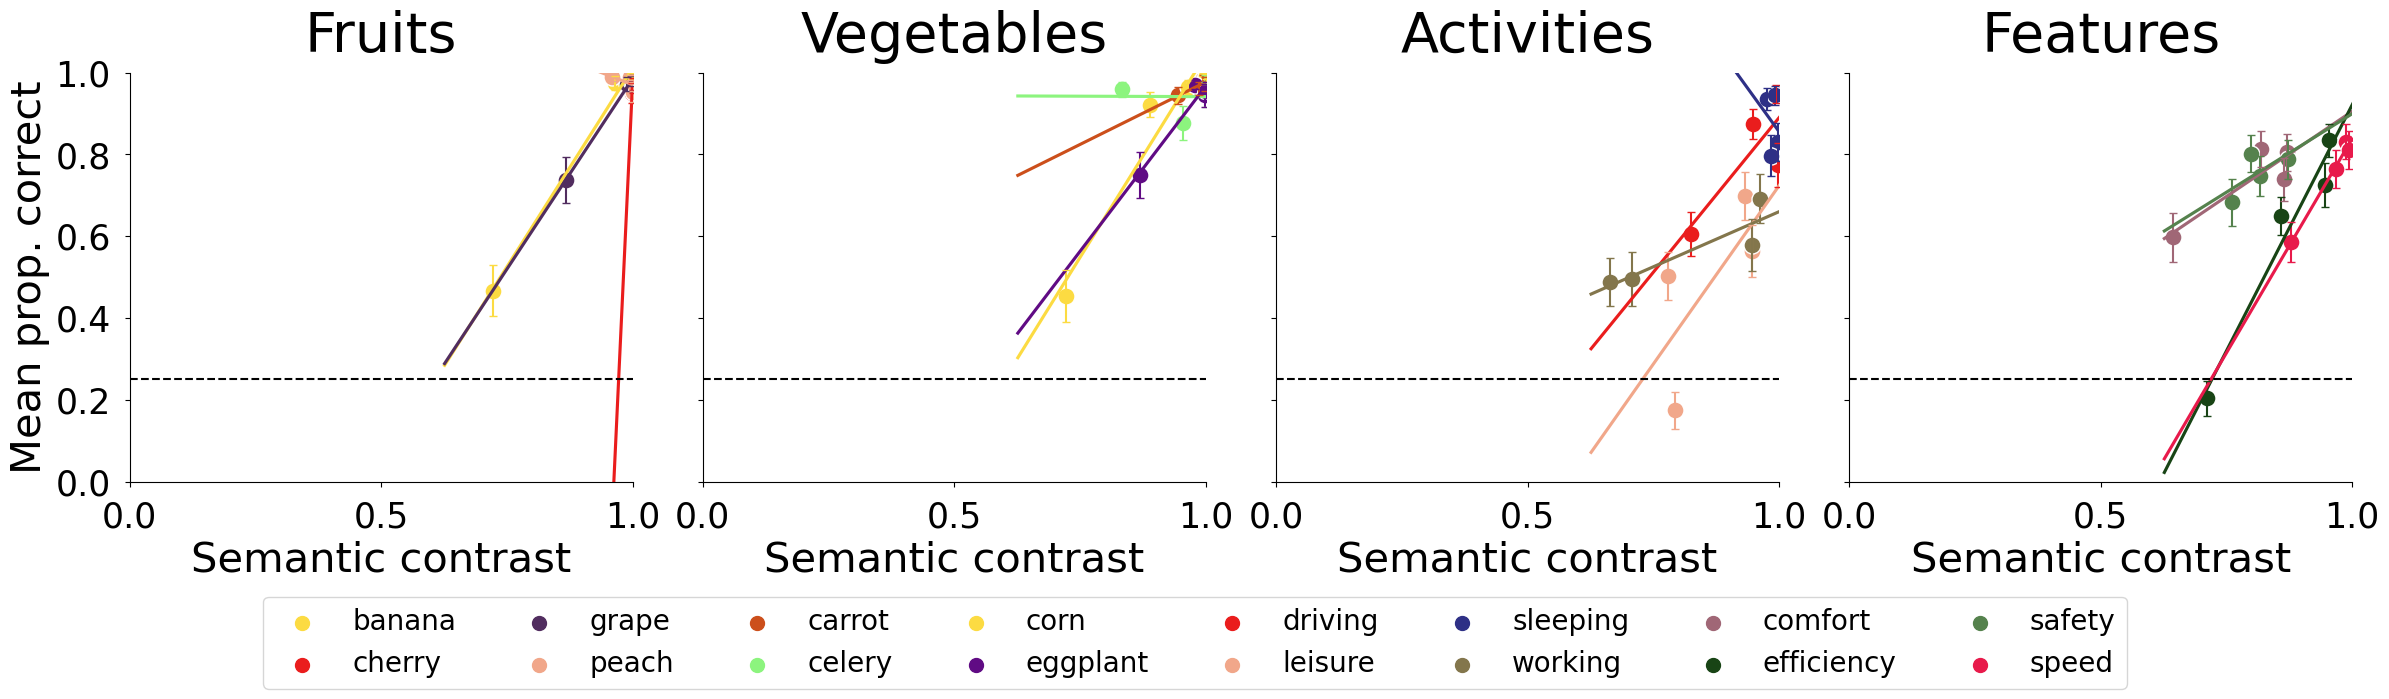

In [215]:
# Define custom color dictionaries for each facet
titles = ['Fruits',  'Vegetables', 'Activities', 'Features']
cd =  {
        'banana': '#fcdb42',
        'cherry': '#ea1d1d',
        'grape':'#512d5f',
        'peach':  '#f1a78a',
        'carrot': '#cc4f1b', 
        'celery':  '#8cf47e',
        'corn':  '#fcdb42',
        'eggplant':  '#600b84',
        'driving': '#ea1d1d',
        'leisure':  '#f1a78a',
        'sleeping':  '#2e3086',
        'working': '#83764c', 
        'comfort':'#a06776',
        'efficiency': '#184415', 
        'safety':'#55824d', 
        'speed': '#e81a4b'
  
}
# Create FacetGrid
g = sns.FacetGrid(
    data=clean_df_human_grouped,
    col='concept_cat',
    hue='answer',
    palette=cd,
    height=6,
    aspect=1,
    col_order=['fruits', 'vegetables', 'activities', 'features']
)

# Add scatter points
g.map_dataframe(
    sns.scatterplot, 
    x='mean_sem_contrast', 
    y='mean_accuracy',
    s=150  # Larger points
)

# Add regression lines
g.map_dataframe(
    sns.regplot, 
    x='mean_sem_contrast', 
    y='mean_accuracy', 
    ci=None,
    scatter=False, 
    truncate=False,
    label='_nolegend_'  # Hide from legend
)

# Add error bars
def add_errorbars(data, **kwargs):
    ax = plt.gca()
    for _, row in data.iterrows():
        ax.errorbar(
            x=row['mean_sem_contrast'],
            y=row['mean_accuracy'],
            yerr=row['se_accuracy'],
            fmt='none',
            ecolor=cd[row['answer']],
            capsize=3,
            label='_nolegend_'  # Hide from legend
        )

g.map_dataframe(add_errorbars)

# Set axis limits and labels
g.set(ylim=(0, 1), xlim=(0, 1))
g.set_ylabels('Mean prop. correct', fontsize=30)
g.set_xlabels('Semantic contrast', fontsize=30)

# Create and position legend
handles = [plt.scatter([], [], c=cd[key], label=key, s=100) for key in cd.keys()]
g.figure.legend(handles=handles, loc='lower center', ncol=8, fontsize=20, bbox_to_anchor=(0.5, -0.18))

# Configure axes
for ax, title in zip(g.axes.flat, titles):
    ax.tick_params(axis='both', labelsize=25, pad=10)
    ax.set_title(title, fontsize=40, pad=15)
    ax.set_xticks([0,.5,1])
    ax.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=25)

# Adjust layout
### add an axline at 0.25
for ax in g.axes.flat:
    ax.axhline(0.25, ls='--', c='black')
plt.subplots_adjust(bottom=0.2,wspace=1.5) 
plt.tight_layout()

plt.savefig('../../plots/accuracy_v_sem_contrast.pdf', format='pdf', bbox_inches='tight',dpi=300)
plt.show()

In [40]:
## load in the old data

## data from mukherjee yin sherman lessard schloss
old_data = pd.read_csv('../../data/reg_df_avg.csv', index_col=0)
old_data['concept_cat'] = old_data.apply(lambda x:con_cat_dict[x.concept], axis = 1)


In [41]:
old_data_subject_level = old_data.groupby(['subject_id','concept_cat','concept','pal'], as_index=False).agg({
    'sem_contrast': 'mean',
    'accuracy': 'mean'
}).reset_index(drop=True)



old_data_grouped =  old_data_subject_level.groupby(['concept_cat', 'concept', 'pal'], as_index=False).agg(
        n_subjects=('subject_id', 'nunique'),
        mean_sem_contrast=('sem_contrast', 'mean'),
        mean_accuracy=('accuracy', 'mean'),
        std_accuracy=('accuracy', 'std'),
    ).reset_index(drop=True)


In [42]:
old_data_grouped['se_accuracy'] = old_data_grouped.apply(lambda x: x.std_accuracy/np.sqrt(x.n_subjects), axis=1)

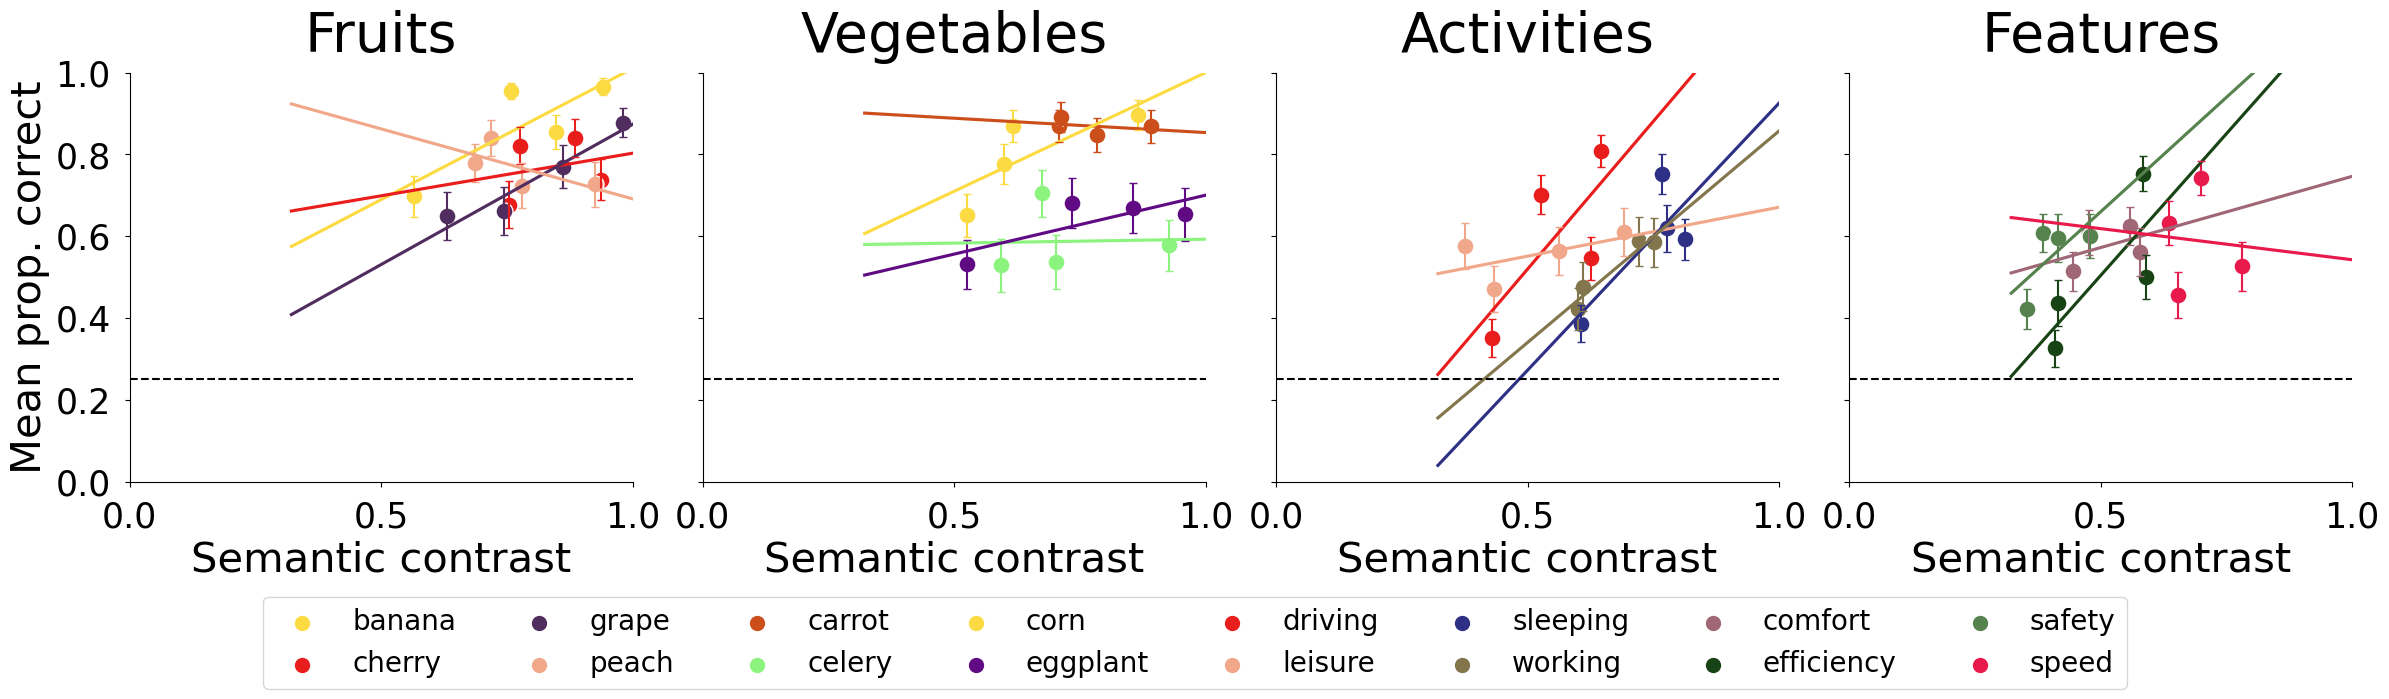

In [43]:
# Define custom color dictionaries for each facet
titles = ['Fruits', 'Vegetables', 'Activities', 'Features']
cd =  {
        'banana': '#fcdb42',
        'cherry': '#ea1d1d',
        'grape':'#512d5f',
        'peach':  '#f1a78a',
        'carrot': '#cc4f1b', 
        'celery':  '#8cf47e',
        'corn':  '#fcdb42',
        'eggplant':  '#600b84',
        'driving': '#ea1d1d',
        'leisure':  '#f1a78a',
        'sleeping':  '#2e3086',
        'working': '#83764c', 
        'comfort':'#a06776',
        'efficiency': '#184415', 
        'safety':'#55824d', 
        'speed': '#e81a4b'
  
}
# Create FacetGrid
g = sns.FacetGrid(
    data=old_data_grouped,
    col='concept_cat',
    hue='concept',
    palette=cd,
    height=6,
    aspect=1,
    col_order = ['fruits','vegetables','activities','features']
)

# Add scatter points
g.map_dataframe(
    sns.scatterplot, 
    x='mean_sem_contrast', 
    y='mean_accuracy',
    s=150  # Larger points
)

# Add regression lines
g.map_dataframe(
    sns.regplot, 
    x='mean_sem_contrast', 
    y='mean_accuracy', 
    ci=None,
    scatter=False, 
    truncate=False,
    label='_nolegend_'  # Hide from legend
)

# Add error bars
def add_errorbars(data, **kwargs):
    ax = plt.gca()
    for _, row in data.iterrows():
        ax.errorbar(
            x=row['mean_sem_contrast'],
            y=row['mean_accuracy'],
            yerr=row['se_accuracy'],
            fmt='none',
            ecolor=cd[row['concept']],
            capsize=3,
            label='_nolegend_'  # Hide from legend
        )

g.map_dataframe(add_errorbars)

# Set axis limits and labels
g.set(ylim=(0, 1), xlim=(0, 1))
g.set_ylabels('Mean prop. correct', fontsize=30)
g.set_xlabels('Semantic contrast', fontsize=30)

# Create and position legend
handles = [plt.scatter([], [], c=cd[key], label=key, s=100) for key in cd.keys()]
g.figure.legend(handles=handles, loc='lower center', ncol=8, fontsize=20, bbox_to_anchor=(0.5, -0.18))

# Configure axes
for ax, title in zip(g.axes.flat, titles):
    ax.tick_params(axis='both', labelsize=25,pad=10)
    ax.set_title(title, fontsize=40, pad=15)
    ax.set_xticks([0,.5,1])
    # ax.set_xticklabels(['.6', '.7', '.8', '.9', '1'], fontsize=15)

# Adjust layout
### add an axline at 0.25
for ax in g.axes.flat:
    ax.axhline(0.25, ls='--', c='black')
plt.subplots_adjust(bottom=0.2,wspace=0.3) 
plt.tight_layout()

plt.savefig('../../plots/accuracy_v_sem_contrast_old.pdf', format='pdf', bbox_inches='tight',dpi=300)
plt.show()

,subject_id,trial_index,condition,pal_source,order_num,category,repetition,answer,bar_col,response,accuracy,total_accuracy,rt,concreteness_cond,context,concept_cat,con_pal_conc,pairing_concreteness,pair_labels,pal
8,08ghd74tvd,43,1,"""uw_711""",3,"""p6""",0,banana,#fcdb42,banana,1,4.0,7312.0,conc,within,fruits,1p6banana,conc,fruit1,14
9,08ghd74tvd,43,1,"""uw_711""",3,"""p6""",0,grape,#5e2b3a,grape,1,4.0,7312.0,conc,within,fruits,1p6grape,conc,fruit1,14
10,08ghd74tvd,43,1,"""uw_711""",3,"""p6""",0,eggplant,#000000,eggplant,1,4.0,7312.0,conc,within,vegetables,1p6eggplant,conc,veg2,14
11,08ghd74tvd,43,1,"""uw_711""",3,"""p6""",0,celery,#8cf47e,celery,1,4.0,7312.0,conc,within,vegetables,1p6celery,conc,veg2,14
12,08ghd74tvd,44,1,"""uw_711""",3,"""p3""",0,efficiency,#ffffff,speed,0,1.0,24871.0,abs,within,features,1p3efficiency,abs,feat1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28611,7rb04x3at5,8644,0,"""uw_710""",0,"""p1""",7,grape,#512d5f,grape,1,2.0,7467.0,conc,within,fruits,0p1grape,conc,fruit1,1
28612,7rb04x3at5,8645,0,"""uw_710""",0,"""p6""",7,celery,#73cf10,eggplant,0,1.0,11516.0,conc,within,vegetables,0p6celery,conc,veg2,6
28613,7rb04x3at5,8645,0,"""uw_710""",0,"""p6""",7,cherry,#ea1d1d,celery,0,1.0,11516.0,conc,within,fruits,0p6cherry,conc,fruit2,6
28614,7rb04x3at5,8645,0,"""uw_710""",0,"""p6""",7,eggplant,#600b84,cherry,0,1.0,11516.0,conc,within,vegetables,0p6eggplant,conc,veg2,6


In [45]:
old_data =pd.read_csv('../../data/clean_df_f.csv', index_col=0)
old_data['pal'] = old_data.apply(lambda x: (int(x.category.split("p")[1].split('"')[0])+8) if x.condition==1 else int(x.category.split("p")[1].split('"')[0]), axis=1)


In [46]:
plot_df_old_data = old_data.groupby(['bar_col','con_pal_conc','subject_id','pal','condition','response' ]).\
apply(lambda x: len(x)/8).reset_index(name= 'num_times_picked')
col_dict= {a:a for a in plot_df_old_data.bar_col.unique()}
plot_df_backup = plot_df_old_data.copy()
rows_to_add = []

for pal in plot_df_backup.pal.unique():
    dp = plot_df_backup[plot_df_backup.pal == pal]
    for cond in dp.condition.unique():
        dpp = dp[dp.condition == cond]
        concepts = dpp.response.unique()
        for col in dpp.bar_col.unique():
            dppp = dpp[dpp.bar_col == col]
            for subj in dppp.subject_id.unique():
                dp_ = dppp[dppp.subject_id == subj]
                for conc in concepts:
                    if conc not in dp_.response.unique():
                        rows_to_add.append([col, 'NA', subj, pal, cond, conc, 0])

# Create a DataFrame from the collected rows and concatenate it with the original DataFrame
if rows_to_add:
    new_rows_df = pd.DataFrame(rows_to_add, columns=plot_df_old_data.columns)
    plot_df_old_data = pd.concat([plot_df_old_data, new_rows_df], ignore_index=True)


In [47]:

true_assignments_old =[
{"banana": "#d0b85a", "carrot": "#cc4f1b", "corn": "#ffffff", "grape": "#512d5f"},
{"cherry": "#ea1d1d", "driving": "#3efe44", "peach": "#f1a78a", "sleeping": "#512d5f"},
{"comfort": "#a06776", "working": "#000000", "safety": "#55824d", "leisure": "#e81a4b"},
{"celery": "#608218", "efficiency": "#5e78a1", "eggplant": "#600b84", "speed": "#e81a4b"},
{"banana": "#fcdb42", "grape": "#600b84", "leisure": "#a0bae6", "working": "#3b3b3b"},
{"celery": "#73cf10", "cherry": "#ea1d1d", "eggplant": "#600b84", "peach": "#f7a75a"},
{"carrot": "#cc4f1b", "comfort": "#a06776", "corn": "#fcdb42", "safety": "#55824d"},
{"driving": "#184415", "efficiency": "#7ec6ba", "sleeping": "#512d5f", "speed": "#e81a4b"},

{"carrot": "#cc4f1b", "cherry": "#ea1d1d", "corn": "#d5b811", "peach": "#f1a78a"},
{"banana": "#d0b85a", "driving": "#ea1d1d", "grape": "#b62ef2", "sleeping": "#1c3d61"},
{"efficiency": "#ffffff", "leisure": "#90689f", "speed": "#e81a4b", "working": "#3b3b3b"},
{"celery": "#0e8a19", "comfort": "#a06776", "eggplant": "#600b84", "safety": "#d0e942"},
{"cherry": "#ea1d1d", "leisure": "#d5a9e4", "peach": "#f1a78a", "working": "#3b3b3b"},
{"banana": "#fcdb42", "celery": "#8cf47e", "eggplant": "#000000", "grape": "#5e2b3a"},
{"carrot": "#ac6619", "corn": "#d0b85a", "efficiency": "#5e78a1", "speed": "#e81a4b"},
{"comfort": "#a06776", "driving": "#ea1d1d", "safety": "#d0e942", "sleeping": "#000000"}
]

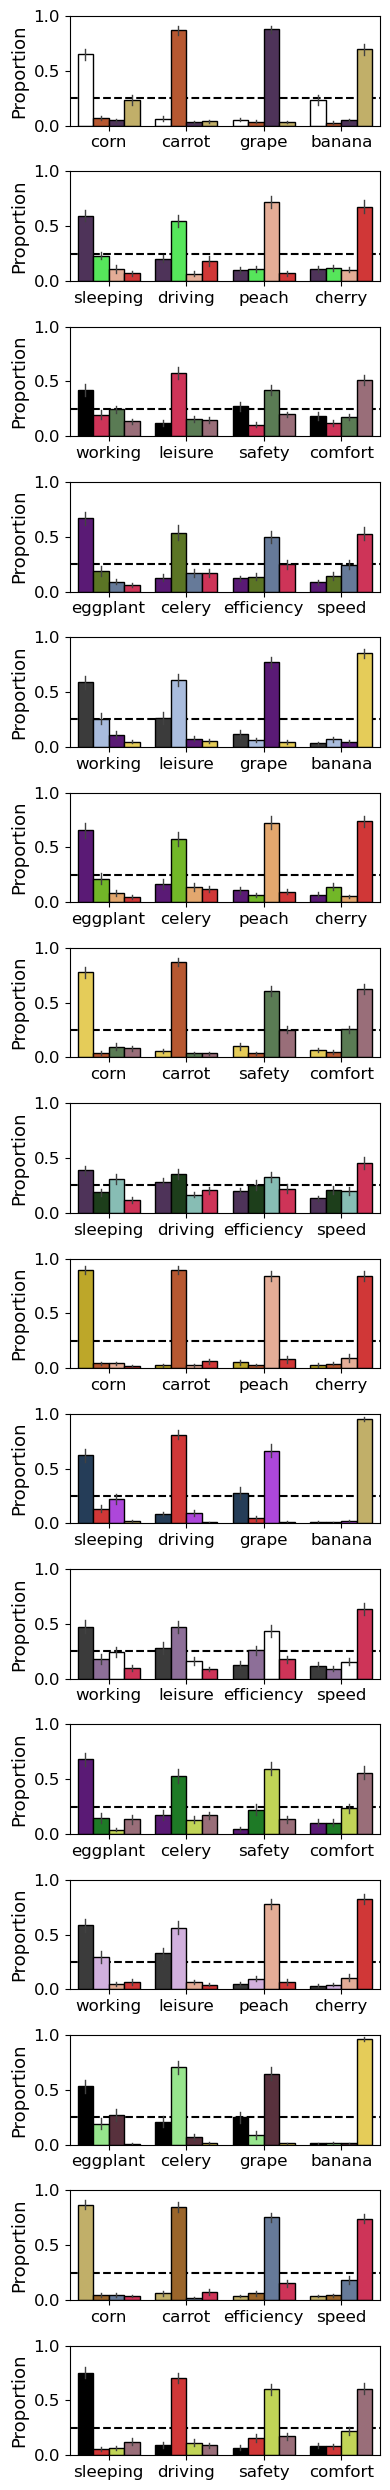

In [48]:

col_dict= {a:a for a in plot_df_old_data.bar_col.unique()}



fig = plt.figure(figsize=(4,25))
plt.rcParams['pdf.fonttype'] = 42
sp=1

for j in range(16):
    

    pdf = plot_df_old_data[(plot_df_old_data.pal ==j+1)]
    
    hue_ord=[]
    this_p = plist[j]
    for p in this_p:
        hue_ord.append(true_assignments_old[j][p])
    

    #sns.set_theme(style="white",rc = {'patch.linewidth': 0.5, 'patch.edgecolor':'black',})

    g = sns.barplot(ax = fig.add_subplot(16,1,sp),
        data=pdf,
        color = 'black',
        x="response", 
        y="num_times_picked",
        hue="bar_col", 
        palette =col_dict,
        errorbar='se', 
        order = plist[j], 
        hue_order=hue_ord,
        errwidth=1,
        edgecolor='black'
    )
    plt.axhline( y=0.25, ls='--', c='black', zorder=0)
    plt.xlabel('')
    ax = plt.gca()
    ax.get_legend().remove()
    plt.ylabel('Proportion', fontsize=13)
    plt.ylim(0,1)
    plt.yticks([0,0.5,1])
    plt.tick_params(labelsize=12)
    
  
    #plt.show()

    
    sp+=1
plt.tight_layout()

plt.savefig(f'../../plots/match_task_patterns_humans_old.pdf',format='pdf')
    


### correlation between human guesses and simulations

In [72]:
plot_df_human

,bar_col,con_pal_conc,subject_id,category,condition,response,num_times_picked
0,#000000,"""set1""15sleeping",0tw0ow8ems,15,"""set1""",sleeping,1.000
1,#000000,"""set1""15sleeping",1vvjhct8y6,15,"""set1""",driving,0.125
2,#000000,"""set1""15sleeping",1vvjhct8y6,15,"""set1""",safety,0.125
3,#000000,"""set1""15sleeping",1vvjhct8y6,15,"""set1""",sleeping,0.750
4,#000000,"""set1""15sleeping",1xxsddld4c,15,"""set1""",sleeping,1.000
...,...,...,...,...,...,...,...
11259,#f1a78a,NA,ysk7o5m4yd,8,"""set1""",cherry,0.000
11260,#f1a78a,NA,ysk7o5m4yd,8,"""set1""",corn,0.000
11261,#f1a78a,NA,yt8o923pd4,8,"""set1""",carrot,0.000
11262,#f1a78a,NA,yt8o923pd4,8,"""set1""",cherry,0.000


array(['15', '9', '1', '7', '10', '5', '12', '4', '13', '11', '0', '3',
       '2', '6', '14', '8'], dtype=object)

In [80]:
plot_df_human['category'] = plot_df_human['category'].astype('int')
human_response_patterns = plot_df_human.groupby(['category','response','bar_col'], as_index=False)['num_times_picked'].mean().sort_values(by=['category','response','bar_col']).reset_index(drop=True)
simulation_response_pattersn = plot_df_sim.sort_values(by=['pal','concept','color']).reset_index(drop=True)

In [83]:
pearsonr(human_response_patterns['num_times_picked'],simulation_response_pattersn['num_times_picked'])

PearsonRResult(statistic=0.9585173634073716, pvalue=1.8245496730723575e-140)

### prepare dataframes for mixed effects regression models

In [177]:
### read in gpt_cor_df
from scipy.stats import entropy
gpt_cor_df = pd.read_csv('../../data/gpt_cor_df.csv')
gpt_cor_df = gpt_cor_df[gpt_cor_df.concept.isin(gpt_assoc_hex_images.concept.unique())]


In [178]:
gpt_cor_df['entropy_gpt4'] = gpt_cor_df['concept'].apply(lambda x: entropy(gpt_assoc_hex_images[gpt_assoc_hex_images.concept==x].iloc[:,1:].values[0]))


gpt_cor_df['normalized_H_add_inv_gpt4'] = 1-(gpt_cor_df['entropy_gpt4']-gpt_cor_df['entropy_gpt4'].min())/(gpt_cor_df['entropy_gpt4'].max()-gpt_cor_df['entropy_gpt4'].min())
gpt_cor_df['log_spec_gpt4'] = np.log(gpt_cor_df['normalized_H_add_inv_gpt4']+ 1e-5) 

In [179]:
gpt_cor_df

,concept,cor_noanchor,cor_anchor,cor_multiple,cor_images,cor_hex_images,google_images,specificity,mean_sh,category,normalized_H_add_inv,log_spec,entropy_gpt4,normalized_H_add_inv_gpt4,log_spec_gpt4
3,reliability,0.252390,0.289485,0.165143,0.167025,0.105734,0.561314,0.235128,0.664014,properties,0.011532,-4.461738,4.185536,0.031306,-3.463630
10,safety,0.392022,0.588806,0.587415,0.645133,0.578836,0.461874,0.235534,0.827514,properties,0.026377,-3.634866,4.139555,0.072101,-2.629543
11,working,0.462495,0.483047,0.608501,0.410520,0.435848,0.719960,0.236000,0.890544,activities,0.043349,-3.138235,4.202696,0.016082,-4.129446
12,driving,0.523407,0.631686,0.549226,0.581595,0.564950,-0.020315,0.236151,0.899922,activities,0.048832,-3.019163,4.149002,0.063720,-2.753103
13,speed,0.523635,0.556521,0.519804,0.376991,0.496685,-0.363968,0.237211,0.935523,properties,0.087156,-2.439936,4.143047,0.069003,-2.673457
19,efficiency,0.579050,0.662337,0.643191,0.617639,0.714534,0.344214,0.235612,0.845830,properties,0.029214,-3.532750,4.184571,0.032163,-3.436636
21,leisure,0.591323,0.672463,0.666997,0.711443,0.714873,0.418405,0.235380,0.838581,activities,0.020736,-3.875378,4.191555,0.025966,-3.650573
23,comfort,0.629819,0.711536,0.608778,0.634855,0.700754,0.482628,0.235932,0.885408,properties,0.040862,-3.197320,4.220822,0.000000,-11.512925
28,grape,0.684791,0.657513,0.675553,0.781266,0.745766,0.173130,0.247913,0.982045,fruits_2,0.455655,-0.785997,3.866776,0.314116,-1.157960
31,eggplant,0.713172,0.677428,0.762320,0.752244,0.707060,0.057776,0.249704,0.984437,vegetables,0.514239,-0.665047,3.313738,0.804783,-0.217170


In [181]:
# Extract the color index
clean_df_human['color_index'] = clean_df_human['bar_col'].map(
    lambda col: color_dict.loc[color_dict['color_hex'] == col, 'color_index'].squeeze()
)
# also do this for the old data
old_data['color_index'] = old_data['bar_col'].map(
    lambda col: color_dict.loc[color_dict['color_hex'] == col, 'color_index'].squeeze()
)

# Map the rating based on the answer and color index
clean_df_human['rating'] = clean_df_human.apply(
    lambda x: gpt_assoc_hex_images.loc[gpt_assoc_hex_images.concept == x['answer'], x['color_index']].squeeze(), axis=1
)
# also do this for the old data
old_data['rating'] = old_data.apply(
    lambda x: ratings3.loc[ratings3.index == x['answer'], x['color_index']].squeeze(), axis=1
)

clean_df_human['log_spec'] = clean_df_human.apply(
    lambda x: gpt_cor_df.loc[gpt_cor_df.concept == x['answer'], 'log_spec_gpt4'].squeeze(), axis=1
)
# also do this for the old data
old_data['log_spec'] = old_data.apply(
    lambda x: gpt_cor_df.loc[gpt_cor_df.concept == x['answer'], 'log_spec'].squeeze(), axis=1
)

In [182]:
clean_df_human

,subject_id,trial_index,condition,pal_source,order_num,category,repetition,answer,bar_col,response,...,rt,concreteness_cond,context,concept_cat,con_pal_conc,pair_labels,sem_contrast,color_index,rating,log_spec
0,pv8mjorbc3,0,"""set1""","""uw_71""",4.0,12,0.0,working,#777777,working,...,12340.0,mix,across,activities,"""set1""12working",act2,0.962,26,0.625,-4.129446
1,pv8mjorbc3,0,"""set1""","""uw_71""",4.0,12,0.0,leisure,#4bcf8e,leisure,...,12340.0,mix,across,activities,"""set1""12leisure",act2,0.932,35,0.742,-3.650573
2,pv8mjorbc3,0,"""set1""","""uw_71""",4.0,12,0.0,peach,#f1a78a,peach,...,12340.0,mix,across,fruits,"""set1""12peach",fruit2,0.959,47,0.875,-0.105359
3,pv8mjorbc3,0,"""set1""","""uw_71""",4.0,12,0.0,cherry,#ea1d1d,cherry,...,12340.0,mix,across,fruits,"""set1""12cherry",fruit2,1.000,62,0.875,-0.043448
4,pv8mjorbc3,1,"""set1""","""uw_71""",4.0,10,0.0,working,#632b14,working,...,18232.0,abs,within,activities,"""set1""10working",act2,0.664,45,0.342,-4.129446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22523,hja5vlht4p,5950,"""set2""","""uw_71""",0.0,5,7.0,cherry,#ea1d1d,cherry,...,9665.0,mix,across,fruits,"""set2""5cherry",fruit2,1.000,62,0.875,-0.043448
22524,hja5vlht4p,5951,"""set2""","""uw_71""",0.0,7,7.0,sleeping,#000000,sleeping,...,7953.0,mix,across,activities,"""set2""7sleeping",act1,0.983,24,0.800,-1.996819
22525,hja5vlht4p,5951,"""set2""","""uw_71""",0.0,7,7.0,driving,#d5b811,speed,...,7953.0,mix,across,activities,"""set2""7driving",act1,0.824,68,0.675,-2.753103
22526,hja5vlht4p,5951,"""set2""","""uw_71""",0.0,7,7.0,efficiency,#67cf5c,driving,...,7953.0,mix,across,features,"""set2""7efficiency",feat1,0.858,51,0.732,-3.436636


In [232]:
mixed_models_df = clean_df_human[['subject_id','trial_index','category',
                                  'answer','concept_cat','color_index',
                                  'sem_contrast','rating','log_spec','accuracy']]
# also do this for the old data
old_data_clean = old_data[['subject_id','trial_index','pal',
                                  'answer','concept_cat','color_index',
                                  #'sem_contrast',
                                  'rating','log_spec','accuracy']]

### rename some columns

mixed_models_df = mixed_models_df.rename(columns={
    'category':'palette',
    'answer':'concept',
})
# also do this for the old data

old_data_clean = old_data_clean.rename(columns={
    'pal':'palette',
    'answer':'concept',
})



In [ ]:
mixed_models_df.to_csv('../../data/mixed_effect_model_df.csv')

In [233]:
mixed_models_df['palette'] = mixed_models_df['palette'].astype('int')
old_data_clean['palette'] = old_data_clean['palette'].astype('int')

mixed_models_df['palette'] = mixed_models_df['palette'] +1

In [241]:
old_data_clean['conc_pal'] = old_data_clean['palette'].astype('string')+'_'+old_data_clean['concept']
mixed_models_df['conc_pal'] = mixed_models_df['palette'].astype('string')+'_'+mixed_models_df['concept']


In [244]:

tmp1 = mixed_models_df[['subject_id','trial_index','conc_pal','concept','palette','accuracy']]
tmp1['condition'] = 'gpt'
tmp2 = old_data_clean[['subject_id','trial_index','conc_pal','concept','palette','accuracy']]
tmp2['condition'] = 'human'

human_v_gpt_mixed_model_df = pd.concat([tmp1,tmp2], ignore_index=True).reset_index(drop=True)
human_v_gpt_mixed_model_df.to_csv('../../data/human_v_gpt_mixed_model_df.csv')

0        12
1        12
2        12
3        12
4        10
         ..
22523     5
22524     7
22525     7
22526     7
22527     7
Name: palette, Length: 22528, dtype: object

In [203]:
mixed_models_df['palette'] = mixed_models_df['palette'].astype('int')
# also do this for the old data
old_data_clean['palette'] = old_data_clean['palette'].astype('int')

In [223]:
gpt_pal_data_summarized = mixed_models_df.groupby(['concept_cat','concept','palette'])['accuracy'].mean().reset_index().sort_values(by=['concept_cat','concept','palette']).reset_index(drop=True)

In [224]:
human_pal_data_summarized = old_data_clean.groupby(['concept_cat','concept','palette'])['accuracy'].mean().reset_index().sort_values(by=['concept_cat','concept','palette']).reset_index(drop=True)

In [225]:
print(f'mean accuracy for human palettes : {human_pal_data_summarized.accuracy.mean()} \n mean accuracy for gpt palettes : {gpt_pal_data_summarized.accuracy.mean()}')
print(f'sd for human palettes : {human_pal_data_summarized.accuracy.std()} \n sd for gpt palettes : {gpt_pal_data_summarized.accuracy.std()}')

mean accuracy for human palettes : 0.657748909883721 
 mean accuracy for gpt palettes : 0.8084918039405684
sd for human palettes : 0.15374357621379942 
 sd for gpt palettes : 0.1960329718171044


In [226]:
ttest_rel(gpt_pal_data_summarized['accuracy'],human_pal_data_summarized['accuracy'])

TtestResult(statistic=8.261608367954246, pvalue=1.245184641532955e-11, df=63)

In [227]:
old_data_clean

,subject_id,trial_index,palette,concept,concept_cat,color_index,rating,log_spec,accuracy
8,08ghd74tvd,43,14,banana,fruits,69,0.879592,-0.415600,1
9,08ghd74tvd,43,14,grape,fruits,30,0.641786,-0.785997,1
10,08ghd74tvd,43,14,eggplant,vegetables,24,0.217933,-0.665047,1
11,08ghd74tvd,43,14,celery,vegetables,52,0.741827,0.000010,1
12,08ghd74tvd,44,11,efficiency,features,28,0.646050,-3.532750,0
...,...,...,...,...,...,...,...,...,...
28611,7rb04x3at5,8644,1,grape,fruits,14,0.885867,-0.785997,1
28612,7rb04x3at5,8645,6,celery,vegetables,64,0.820577,0.000010,0
28613,7rb04x3at5,8645,6,cherry,fruits,62,0.906276,-1.000599,0
28614,7rb04x3at5,8645,6,eggplant,vegetables,7,0.933077,-0.665047,0


### Stim gen for GPT experiment

In [49]:
import random

def plot_bar_charts(true_assignments):
    data = []

    for palette_num, assignment in enumerate(true_assignments):
        keys = list(assignment.keys())
        colors = list(assignment.values())
        heights = [random.uniform(8, 12) for _ in keys]

        for shift in range(4):
            plt.figure(figsize=(10, 6))
            plt.gca().set_facecolor((143/255, 143/255, 143/255))

            # Create a shifted version of the keys and colors
            shifted_keys = np.roll(keys, shift)
            shifted_colors = np.roll(colors, shift)

            plt.bar(['A', 'B', 'C', 'D'], heights, color=shifted_colors)
            plt.xlabel('Concepts')
            plt.ylabel('Values')
            plt.title(f'Bar Plot of Concepts and Colors (Shift {shift + 1})')

            # Add the keys above the plot
            ### shuffle the labels in shifted_keys before plotting

            shifted_keys_copy = shifted_keys.copy()
            random.shuffle(shifted_keys_copy)
            label_options = []
            for i, key in enumerate(shifted_keys_copy):
                label_options.append(key)
                plt.text(1.5, max(heights) + 2 + i * 2, key, ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black'), size=15)
            plt.ylim(0, max(heights) + 6 + len(keys) * 1.5)  # Adjust y-axis limit to fit the labels

            sns.despine()

            ### of the remaining spines make them thicker

            plt.gca().spines['left'].set_linewidth(2)
            plt.gca().spines['bottom'].set_linewidth(2)

            ### make it tight layout
            plt.tight_layout()
            ### remove y axis ticks and labels
            plt.yticks([])
            plt.gca().yaxis.set_ticks_position('none')
            
            plt.ylabel('')  


            # Save the plot
            fname = f'{palette_num}_{shift + 1}.png'
            os.makedirs('../../data/match_task_images', exist_ok=True)
            plt.savefig(os.path.join('../../data/match_task_images',fname))
            # plt.show()
            plt.close()

            # Append data to the dataframe
            data.append({
                'palette': palette_num,
                'order_num': shift + 1,
                'label_options': label_options[::-1],
                'answer_key': list(shifted_keys),
                'bar_cols': list(shifted_colors),
                'fname': fname
            })

    df = pd.DataFrame(data)
    return df


In [50]:

df = plot_bar_charts(true_assignments)


In [51]:
df['prompt'] = "Q: In this graph, map each of the four words above the bars to the correct bar based on its color. \
Each word should be mapped to a single colored bar.  Think about the optimal mapping between all words and colors.\
The bars are indexed used the letters A, B, C, and D \n \
Format your answer like this - A: word 1, B: word 2, C: word 3, D: word 4 \n \
Respond in json format\n \
A:"
df.to_csv('../../data/match_task_input.csv', index=False)

In [52]:
df['prompt'][0]

'Q: In this graph, map each of the four words above the bars to the correct bar based on its color. Each word should be mapped to a single colored bar.  Think about the optimal mapping between all words and colors.The bars are indexed used the letters A, B, C, and D \n Format your answer like this - A: word 1, B: word 2, C: word 3, D: word 4 \n Respond in json format\n A:'

## assignment inference gpt results

In [53]:
import json
import ast

In [54]:
def parse_response(response):
    # Remove the ```json\n and \n``` parts
    json_str = response.strip('```json\n').strip('\n```')
    # Parse the JSON string
    parsed_dict = json.loads(json_str)
    # Extract the values as a list
    return list(parsed_dict.values())
# Function to compare the lists
def compare_lists(parsed_responses, answer_key):
    return [1 if parsed_responses[i] == answer_key[i] else 0 for i in range(len(answer_key))]


In [55]:
gpt_match_task_df = pd.read_csv('../../data/match_task_output.csv', index_col=0)

In [56]:
gpt_match_task_df['answer_key'] = gpt_match_task_df['answer_key'].apply(ast.literal_eval)
gpt_match_task_df['bar_cols'] = gpt_match_task_df['bar_cols'].apply(ast.literal_eval)
gpt_match_task_df['parsed_response'] = gpt_match_task_df['response'].apply(parse_response)


In [57]:

gpt_match_task_df['accuracies'] = gpt_match_task_df.apply(lambda row: compare_lists(row['parsed_response'], row['answer_key']), axis=1)
gpt_match_task_df['total_accuracy'] = gpt_match_task_df['accuracies'].apply(lambda x: sum(x) / len(x))

In [58]:


bar_col=[]
answer=[]
response=[]
palette=[]
accuracy=[]
total_accuracy=[]
order_num=[]


for index,row in gpt_match_task_df.iterrows():
    
    for i in range(4):
        bar_col.append(row.bar_cols[i])
        answer.append(row.answer_key[i])
        response.append(row.parsed_response[i])
        palette.append(row.palette)
        accuracy.append(row.accuracies[i])
        total_accuracy.append(row['total_accuracy'])
        order_num.append(row.order_num)
        

clean_df_gpt = pd.DataFrame({'order_num':order_num,\
               'palette':palette,'answer':answer,\
               'bar_col':bar_col,'response':response,\
             'accuracy':accuracy,'total_accuracy':total_accuracy})

clean_df_gpt['concreteness_cond'] = clean_df_gpt.apply(lambda x: 'conc' if x.palette in [8,13] \
                                                   else ('abs' if x.palette in [10,15]\
                                                              else'mix'), axis=1 )

clean_df_gpt['context']= clean_df_gpt.apply(lambda x: 'within' if x.concreteness_cond in ['conc','abs'] else 'across', axis = 1)

clean_df_gpt['concept_cat'] = clean_df_gpt.apply(lambda x:con_cat_dict[x.answer], axis = 1)

clean_df_gpt['con_pal_conc'] = str(clean_df_gpt['palette']) + clean_df_gpt['answer']

In [59]:
plot_df_gpt = clean_df_gpt.groupby(['bar_col','con_pal_conc','palette','response' ]).\
apply(lambda x: len(x)/4).reset_index(name= 'num_times_picked')
col_dict= {a:a for a in plot_df_gpt.bar_col.unique()}

In [60]:
plot_df_gpt_backup = plot_df_gpt.copy()
rows_to_add = []

for pal in plot_df_gpt_backup.palette.unique():
    dp = plot_df_gpt_backup[plot_df_gpt_backup.palette == pal]
    concepts = dp.response.unique()
    for col in dp.bar_col.unique():
        dpp = dp[dp.bar_col == col]
        for conc in concepts:
            if conc not in dpp.response.unique():
                rows_to_add.append([col, 'NA', pal, conc, 0])

# Create a DataFrame from the collected rows and concatenate it with the original DataFrame
if rows_to_add:
    new_rows_df = pd.DataFrame(rows_to_add, columns=plot_df_gpt.columns)
    plot_df_gpt = pd.concat([plot_df_gpt, new_rows_df], ignore_index=True)

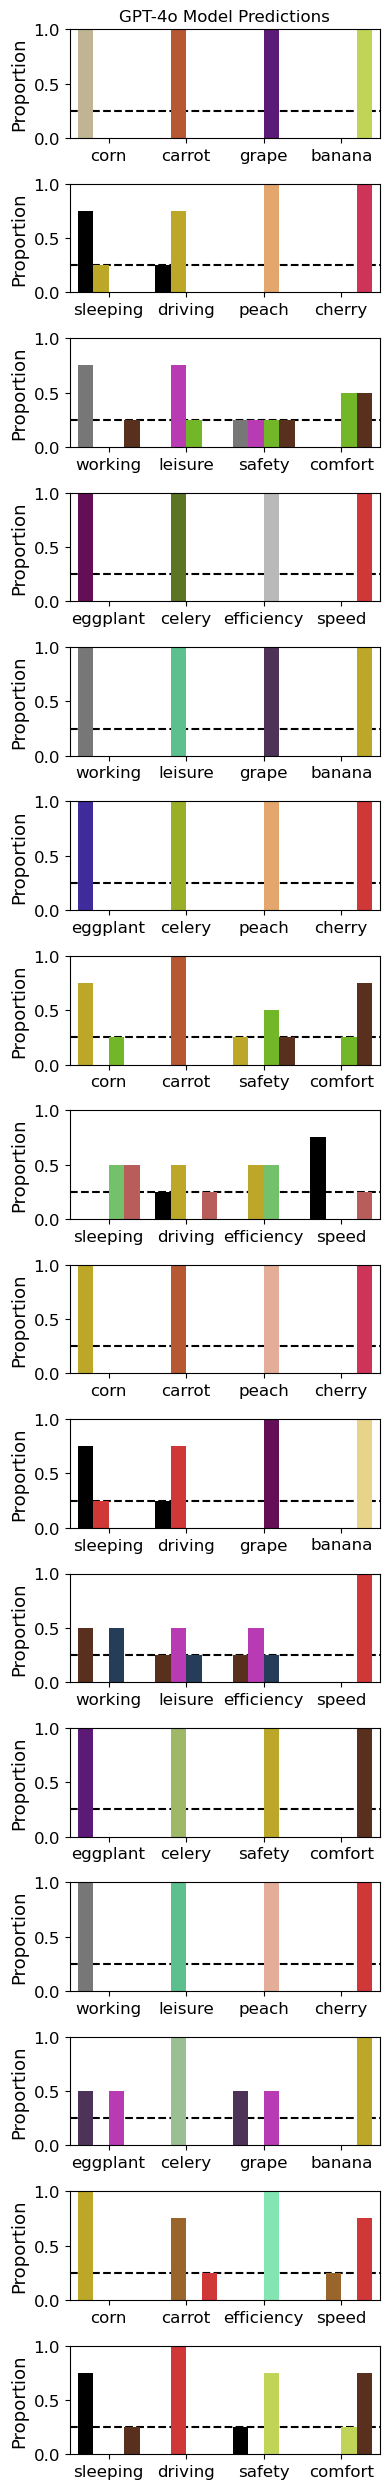

In [61]:
fig = plt.figure(figsize=(4,25))
plt.rcParams['pdf.fonttype'] = 42
sp=1

for j in range(16):
    

    pdf = plot_df_gpt[(plot_df_gpt.palette ==j)]
    
    hue_ord=[]
    this_p = plist[j]
    for p in this_p:
        hue_ord.append(true_assignments[j][p])
    

    #sns.set_theme(style="white",rc = {'patch.linewidth': 0.5, 'patch.edgecolor':'black',})

    g = sns.barplot(ax = fig.add_subplot(16,1,sp),
        data=pdf,color = 'black',
        x="response", y="num_times_picked", hue="bar_col", palette =col_dict,
        errorbar='se', order = plist[j], hue_order= hue_ord
    )
    if j==0:
        plt.title('GPT-4o Model Predictions')
    plt.axhline( y=0.25, ls='--', c='black', zorder=0)
    plt.xlabel('')
    ax = plt.gca()
    ax.get_legend().remove()
    plt.ylabel('Proportion', fontsize=13)
    plt.ylim(0,1)
    plt.yticks([0,0.5,1])
    plt.tick_params(labelsize=12)
    
    sp+=1
plt.tight_layout()


#plt.savefig(f'../human_data_faceted.pdf',format='pdf')
    


In [62]:
human_mean_responses = \
    plot_df.groupby(['category','bar_col','response'])['num_times_picked'].mean().reset_index()
gpt_mean_responses = \
    plot_df_gpt.groupby(['palette','bar_col','response'])['num_times_picked'].mean().reset_index()

In [82]:
from scipy.stats import pearsonr

In [64]:
human_mean_responses['category'] = human_mean_responses['category'].apply(lambda x: int(x.strip('"')))

human_mean_responses = human_mean_responses.sort_values(by=['category','bar_col','response']).reset_index(drop=True)

In [65]:
pearsonr(human_mean_responses.num_times_picked, gpt_mean_responses.num_times_picked)

PearsonRResult(statistic=0.9023770663838087, pvalue=7.710375925552672e-95)

In [66]:
plot_df_human.

,bar_col,con_pal_conc,subject_id,category,condition,response,num_times_picked
0,#000000,"""set1""15sleeping",0tw0ow8ems,15,"""set1""",sleeping,1.000
1,#000000,"""set1""15sleeping",1vvjhct8y6,15,"""set1""",driving,0.125
2,#000000,"""set1""15sleeping",1vvjhct8y6,15,"""set1""",safety,0.125
3,#000000,"""set1""15sleeping",1vvjhct8y6,15,"""set1""",sleeping,0.750
4,#000000,"""set1""15sleeping",1xxsddld4c,15,"""set1""",sleeping,1.000
...,...,...,...,...,...,...,...
3964,#f7db7c,"""set1""9banana",ymlmsnxcks,9,"""set1""",sleeping,0.125
3965,#f7db7c,"""set1""9banana",yq3vexj9py,9,"""set1""",banana,1.000
3966,#f7db7c,"""set1""9banana",yql2t3175x,9,"""set1""",banana,1.000
3967,#f7db7c,"""set1""9banana",ysk7o5m4yd,9,"""set1""",banana,1.000


In [76]:
clean_df_human_grouped[clean_df_human_grouped.category == '8']    

,concept_cat,answer,category,n_subjects,mean_sem_contrast,mean_accuracy,std_accuracy,se_accuracy
39,fruits,cherry,8,43,1.000,0.988372,0.045757,0.006978
47,fruits,peach,8,43,0.997,0.988372,0.045757,0.006978
51,vegetables,carrot,8,43,0.997,0.985465,0.055964,0.008534
59,vegetables,corn,8,43,1.000,0.991279,0.042217,0.006438
